In [1]:
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import json
import pandas as pd
import seaborn as sns
import numpy as np
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [5]:
paths = [
    '../logfiles/baseline/',
    '../logfiles/experiments/re_pruning/',
    '../logfiles/experiments/gd_top_k_mc_ac_dk/',
    
    '../logfiles/ablation_study/alexnet_mixed/',
    '../logfiles/ablation_study/resnet_mixed/',
    
    '../logfiles/ablation_study/admm_intra/',
    '../logfiles/ablation_study/admm_retrain/',
    
    '../logfiles/ablation_study/gd_top_k/',
    '../logfiles/ablation_study/gd_top_k_mc/',
    '../logfiles/ablation_study/gd_top_k_mc_ac/',
    '../logfiles/ablation_study/gd_top_k_mc_ac_dk/',
    '../logfiles/ablation_study/gd_top_k_mc_ac_dk_admm_intra/',
    '../logfiles/ablation_study/gd_top_k_mc_ac_dk_admm_retrain/',
    
    '../logfiles/ablation_study/re_pruning/',
    '../logfiles/ablation_study/re_pruning_admm_retrain/',
    '../logfiles/ablation_study/re_pruning_admm_intra/',
    '../logfiles/ablation_study/re_pruning_ac/',
    '../logfiles/ablation_study/re_pruning_ac_admm_intra/',
    '../logfiles/ablation_study/re_pruning_ac_admm_retrain/',
    '../logfiles/ablation_study/re_pruning_gd_top_k_mc_ac_dk_admm_intra/'
        ]
logs = []
for path in paths:
    print(path, flush=True)
    fnames = [f for f in listdir(path) if isfile(join(path, f))]
    for fname in fnames:
        if 'json' in fname:
            with open(path+fname, 'r') as f:
                logs.append(json.load(f))
        

../logfiles/baseline/
../logfiles/experiments/re_pruning/
../logfiles/experiments/gd_top_k_mc_ac_dk/
../logfiles/ablation_study/alexnet_mixed/
../logfiles/ablation_study/resnet_mixed/
../logfiles/ablation_study/admm_intra/
../logfiles/ablation_study/admm_retrain/
../logfiles/ablation_study/gd_top_k/
../logfiles/ablation_study/gd_top_k_mc/
../logfiles/ablation_study/gd_top_k_mc_ac/
../logfiles/ablation_study/gd_top_k_mc_ac_dk/
../logfiles/ablation_study/gd_top_k_mc_ac_dk_admm_intra/
../logfiles/ablation_study/gd_top_k_mc_ac_dk_admm_retrain/
../logfiles/ablation_study/re_pruning/
../logfiles/ablation_study/re_pruning_admm_retrain/
../logfiles/ablation_study/re_pruning_admm_intra/
../logfiles/ablation_study/re_pruning_ac/
../logfiles/ablation_study/re_pruning_ac_admm_intra/
../logfiles/ablation_study/re_pruning_ac_admm_retrain/
../logfiles/ablation_study/re_pruning_gd_top_k_mc_ac_dk_admm_intra/


In [15]:
def single_eval(dataset, model, name, specs_to_print, results_to_print, plt_corr = True):
    pd_dict = {}
    for log in logs:
        if (log['METADATA']['EXPERIMENT']['dataset'] == dataset and 
            log['METADATA']['EXPERIMENT']['name'] == name and
            log['METADATA']['EXPERIMENT']['model'] == model):
            outstring = model.upper() + ' ' + dataset.upper() + ' ' + name.upper() + '\n'
            for key in specs_to_print:
                section = None
                if key in log['METADATA']['SPECIFICATION']:
                    section = 'SPECIFICATION'
                if key in log['METADATA']['EXPERIMENT']:
                    section = 'EXPERIMENT'
                
                outstring += key + ':' + log['METADATA'][section][key] + '\n'
                if key not in pd_dict:
                    pd_dict[key] = []
                pd_dict[key].append(float(log['METADATA'][section][key]))
            #outstring += '\n'
            for key in results_to_print:
                if type(log['LOGDATA'][key]) == type([]):
                    outstring += key + ':' + str(round(log['LOGDATA'][key][-1], 2)) + '\n'
                    if key not in pd_dict:
                        pd_dict[key] = []
                    pd_dict[key].append(log['LOGDATA'][key][-1])
                else:
                    outstring += key + ':' + str(round(log['LOGDATA'][key], 2)) + '\n'
                    if key not in pd_dict:
                        pd_dict[key] = []
                    pd_dict[key].append(log['LOGDATA'][key])
                    
            #    if type(log['LOGDATA'][key]) == type([]):
            #        plt.plot(log['LOGDATA'][key], label=key)
            #plt.title(model.upper() + ' ' + dataset.upper() + ' ' + name.upper())
            #plt.legend()
            #plt.show()
            outstring+='\n'
            print(outstring)
                
    if plt_corr:
        pd_df = pd.DataFrame(pd_dict)
        if len(pd_df) > 0:
            pd_df = pd_df.loc[:, (pd_df != pd_df.iloc[0]).any()] #drop const cols
            sns.heatmap(pd_df.corr(), cbar=True, annot=True, cmap='RdBu')
            plt.title(model.upper() + ' ' + dataset.upper() + ' ' + name.upper())
            plt.xticks(rotation=45) 
            plt.show()
            
def cross_eval(datasets, models, name, specs_to_print, results_to_print, plt_corr = True):
    pd_dict = {}
    res_dict = {}
    best_config = {}
    for model in models:
        for dataset in datasets:
            if model not in res_dict:
                res_dict[model] = {}
            if dataset not in res_dict[model]:
                res_dict[model][dataset] = {}
            if model not in best_config:
                best_config[model] = {}
            if dataset not in best_config[model]:
                best_config[model][dataset] = {}
            res_dict[model][dataset]['test_accuracy'] = 0.0
            res_dict[model][dataset]['total_su'] = 1.0
            res_dict[model][dataset]['current_sparsity'] = 0.0
            
            for log in logs:
                if (log['METADATA']['EXPERIMENT']['dataset'] == dataset and 
                    log['METADATA']['EXPERIMENT']['name'] == name and
                    log['METADATA']['EXPERIMENT']['model'] == model):
                    outstring = model.upper() + ' ' + dataset.upper() + ' ' + name.upper() + '\n'
                    
                    if log['LOGDATA']['test_accuracy'][-1] > 1:
                        log['LOGDATA']['test_accuracy'] = [x * 1e-2 for x in log['LOGDATA']['test_accuracy']]
                        
                    #TODO = selectable . in rounding
                    if round(res_dict[model][dataset]['test_accuracy'],2) < round(log['LOGDATA']['test_accuracy'][-1],2):
                        res_dict[model][dataset]['test_accuracy'] = log['LOGDATA']['test_accuracy'][-1]
                        if name != 'baseline':
                            res_dict[model][dataset]['total_su'] = log['LOGDATA']['total_su'][-1]
                            res_dict[model][dataset]['current_sparsity'] = log['LOGDATA']['current_sparsity'][-1]
                            best_config[model][dataset]['METADATA'] = log['METADATA']
                    if round(res_dict[model][dataset]['test_accuracy'],2) == round(log['LOGDATA']['test_accuracy'][-1],2):
                        if name != 'baseline':
                            if round(res_dict[model][dataset]['total_su'],2) < round(log['LOGDATA']['total_su'][-1],2):
                                res_dict[model][dataset]['test_accuracy'] = log['LOGDATA']['test_accuracy'][-1]
                                res_dict[model][dataset]['total_su'] = log['LOGDATA']['total_su'][-1]
                                res_dict[model][dataset]['current_sparsity'] = log['LOGDATA']['current_sparsity'][-1]
                                best_config[model][dataset]['METADATA'] = log['METADATA']
                    
                    for key in specs_to_print:
                        section = None
                        if key in log['METADATA']['SPECIFICATION']:
                            section = 'SPECIFICATION'
                        if key in log['METADATA']['EXPERIMENT']:
                            section = 'EXPERIMENT'

                        outstring += key + ':' + log['METADATA'][section][key] + '\n'
                        if key not in pd_dict:
                            pd_dict[key] = []
                        pd_dict[key].append(float(log['METADATA'][section][key]))
                    #outstring += '\n'
                    for key in results_to_print:
                        if type(log['LOGDATA'][key]) == type([]):
                            outstring += key + ':' + str(round(log['LOGDATA'][key][-1], 2)) + '\n'
                            if key not in pd_dict:
                                pd_dict[key] = []
                            pd_dict[key].append(log['LOGDATA'][key][-1])
                        else:
                            outstring += key + ':' + str(round(log['LOGDATA'][key], 2)) + '\n'
                            if key not in pd_dict:
                                pd_dict[key] = []
                            pd_dict[key].append(log['LOGDATA'][key])

                    #    if type(log['LOGDATA'][key]) == type([]):
                    #        plt.plot(log['LOGDATA'][key], label=key)
                    #plt.title(model.upper() + ' ' + dataset.upper() + ' ' + name.upper())
                    #plt.legend()
                    #plt.show()
                    outstring+='\n'
                    #print(outstring)
    for model in res_dict:
        for dataset in res_dict[model]:
            if res_dict[model][dataset]['test_accuracy'] > 0.0:
                print(name, model, dataset,
                      round(res_dict[model][dataset]['test_accuracy'],2),
                      round(res_dict[model][dataset]['total_su'],2),
                      round(res_dict[model][dataset]['current_sparsity'],2))
                #print(best_config[model][dataset])
    print('\n\n')
    if plt_corr:
        pd_df = pd.DataFrame(pd_dict)
        if len(pd_df) > 0:
            pd_df = pd_df.loc[:, (pd_df != pd_df.iloc[0]).any()] #drop const cols
            sns.heatmap(pd_df.corr(), cbar=True, annot=True, cmap='RdBu')
            plt.title(name.upper())
            plt.xticks(rotation=90) 
            plt.show()
            


In [16]:
datasets = [
    'cifar10', 
    'cifar100', 
    'mnist',
    'imagenet'
]
models = [
    #'resnet18', 
    'alexnet_s', 
    #'lenet', 
    #'mobilenet_v2', 
    #'mobilenet_v3', 
    'vgg8',
    'vgg11', 
    'vgg13', 
    'vgg16'
         ]
plt_corr = False

cross_eval(datasets, models, 'baseline', ['lr', 'epochs', 'train_batch_size'], ['test_accuracy'], plt_corr)


cross_eval(datasets, models, 'admm_intra', 
     ['lr', 'pre_epochs', 'epochs', 're_epochs', 'repeat', 'train_batch_size'], 
     ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
      'current_relative_overhead'], plt_corr)
cross_eval(datasets, models, 'admm_retrain', 
     ['lr', 'pre_epochs', 'epochs', 're_epochs', 'train_batch_size'], 
     ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
      'current_relative_overhead'], plt_corr)

cross_eval(datasets, models, 'gd_top_k', ['lr', 'k', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)
cross_eval(datasets, models, 'gd_top_k_mc', ['lr', 'k', 'se', 'train_batch_size'], 
     ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
      'current_relative_overhead'], plt_corr)
cross_eval(datasets, models, 'gd_top_k_mc_ac', ['lr', 'k', 'se', 'ac', 'train_batch_size'], 
     ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
      'current_relative_overhead'], plt_corr)
cross_eval(datasets, models, 'gd_top_k_mc_ac_dk', ['lr', 'k', 'se', 'ac', 'train_batch_size'], 
     ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
      'current_relative_overhead'], plt_corr)
cross_eval(datasets, models, 'gd_top_k_mc_ac_dk_admm_intra', 
     ['lr', 'k', 'se', 'ac', 'pre_epochs', 'epochs', 're_epochs', 'repeat', 'train_batch_size'], 
     ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
      'current_relative_overhead'], plt_corr)
cross_eval(datasets, models, 'gd_top_k_mc_ac_dk_admm_retrain',  
     ['lr', 'k', 'se', 'ac', 'pre_epochs', 'epochs', 're_epochs', 'train_batch_size'], 
     ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
      'current_relative_overhead'], plt_corr)


cross_eval(datasets, models, 're_pruning', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
      'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'l1', 'l2', 
      'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
      'current_sparsity', 'current_relative_overhead'], plt_corr)
cross_eval(datasets, models, 're_pruning_ac', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
      'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'l1', 'l2', 'ac', 
      'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
      'current_sparsity', 'current_relative_overhead'], plt_corr)


cross_eval(datasets, models, 're_pruning_admm_intra', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
      'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'repeat',
      'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
      'current_sparsity', 'current_relative_overhead'], plt_corr)
cross_eval(datasets, models, 're_pruning_admm_retrain', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
      'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 
      'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
      'current_sparsity', 'current_relative_overhead'], plt_corr)
cross_eval(datasets, models, 're_pruning_ac_admm_intra', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
      'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'ac', 'repeat',
      'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
      'current_sparsity', 'current_relative_overhead'], plt_corr)
cross_eval(datasets, models, 're_pruning_ac_admm_retrain', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
      'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'ac', 
      'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
      'current_sparsity', 'current_relative_overhead'], plt_corr)



cross_eval(datasets, models, 're_pruning_gd_top_k_mc_ac_dk_admm_intra', ['lr', 'prune_epochs', 'metric_q_l', 
      'metric_q_c', 'scale_l', 'scale_c', 'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 
      'magnitude_t_l', 'ac', 'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 
      'total_su_bwd', 'current_sparsity', 'current_relative_overhead'], False)

baseline alexnet_s cifar10 0.74 1.0 0.0
baseline alexnet_s cifar100 0.41 1.0 0.0
baseline vgg8 cifar10 0.77 1.0 0.0
baseline vgg8 cifar100 0.46 1.0 0.0
baseline vgg11 cifar10 0.76 1.0 0.0
baseline vgg11 cifar100 0.36 1.0 0.0
baseline vgg13 cifar10 0.76 1.0 0.0
baseline vgg13 cifar100 0.28 1.0 0.0
baseline vgg16 cifar10 0.72 1.0 0.0
baseline vgg16 cifar100 0.26 1.0 0.0



admm_intra alexnet_s cifar10 0.72 2.17 0.98



admm_retrain alexnet_s cifar10 0.7 1.53 0.98



gd_top_k alexnet_s cifar10 0.73 1.48 0.0



gd_top_k_mc alexnet_s cifar10 0.72 1.47 0.0



gd_top_k_mc_ac alexnet_s cifar10 0.71 1.83 0.0



gd_top_k_mc_ac_dk alexnet_s cifar10 0.73 1.5 0.0
gd_top_k_mc_ac_dk alexnet_s cifar100 0.37 1.51 0.0
gd_top_k_mc_ac_dk vgg8 cifar10 0.75 1.52 0.0
gd_top_k_mc_ac_dk vgg8 cifar100 0.39 1.45 0.0
gd_top_k_mc_ac_dk vgg11 cifar10 0.76 1.48 0.0
gd_top_k_mc_ac_dk vgg11 cifar100 0.35 1.44 0.0
gd_top_k_mc_ac_dk vgg13 cifar10 0.77 1.46 0.0
gd_top_k_mc_ac_dk vgg13 cifar100 0.38 1.44 0.0
gd_top_k_mc_a

In [17]:
datasets = [
    'cifar10', 
    'cifar100', 
    'mnist',
    'imagenet'
]
models = [
    #'resnet18', 
    #'alexnet_s', 
    #'lenet', 
    #'mobilenet_v2', 
    #'mobilenet_v3', 
    'vgg8',
    #'vgg11', 
    #'vgg13', 
    #'vgg16'
         ]
plt_corr = False

for model in models:
    for dataset in datasets:
        single_eval(dataset, model, 'baseline', ['lr', 'epochs', 'train_batch_size'], ['test_accuracy'], plt_corr)


for model in models:
    for dataset in datasets:
        single_eval(dataset, model, 'admm_intra', 
             ['lr', 'pre_epochs', 'epochs', 're_epochs', 'repeat', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 'admm_retrain', 
             ['lr', 'pre_epochs', 'epochs', 're_epochs', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)

for model in models:
    for dataset in datasets:
        single_eval(dataset, model, 'gd_top_k', ['lr', 'k', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 'gd_top_k_mc', ['lr', 'k', 'se', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 'gd_top_k_mc_ac', ['lr', 'k', 'se', 'ac', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 'gd_top_k_mc_ac_dk', ['lr', 'k', 'se', 'ac', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 'gd_top_k_mc_ac_dk_admm_intra', 
             ['lr', 'k', 'se', 'ac', 'pre_epochs', 'epochs', 're_epochs', 'repeat', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 'gd_top_k_mc_ac_dk_admm_retrain',  
             ['lr', 'k', 'se', 'ac', 'pre_epochs', 'epochs', 're_epochs', 'train_batch_size'], 
             ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 'current_sparsity', 
              'current_relative_overhead'], plt_corr)


for model in models:
    for dataset in datasets:
        single_eval(dataset, model, 're_pruning', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
              'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'l1', 'l2', 
              'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
              'current_sparsity', 'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 're_pruning_ac', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
              'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'l1', 'l2', 'ac', 
              'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
              'current_sparsity', 'current_relative_overhead'], plt_corr)


for model in models:
    for dataset in datasets:
        single_eval(dataset, model, 're_pruning_admm_intra', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
              'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'repeat',
              'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
              'current_sparsity', 'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 're_pruning_admm_retrain', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
              'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 
              'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
              'current_sparsity', 'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 're_pruning_ac_admm_intra', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
              'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'ac', 'repeat',
              'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
              'current_sparsity', 'current_relative_overhead'], plt_corr)
        single_eval(dataset, model, 're_pruning_ac_admm_retrain', ['lr', 'prune_epochs', 'metric_q_l', 'metric_q_c', 'scale_l', 'scale_c',
              'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 'magnitude_t_l', 'ac', 
              'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 'total_su_bwd', 
              'current_sparsity', 'current_relative_overhead'], plt_corr)


for model in models:
    for dataset in datasets:
        single_eval(dataset, model, 're_pruning_gd_top_k_mc_ac_dk_admm_intra', ['lr', 'prune_epochs', 'metric_q_l', 
              'metric_q_c', 'scale_l', 'scale_c', 'sample_l', 'sample_c', 'softness_l', 'softness_c', 'magnitude_t_c', 
              'magnitude_t_l', 'l1', 'l2', 'ac', 'train_batch_size'], ['test_accuracy', 'total_su', 'total_su_fwd', 
              'total_su_bwd', 'current_sparsity', 'current_relative_overhead'], False)

VGG8 CIFAR10 BASELINE
lr:1e-1
epochs:100
train_batch_size:256
test_accuracy:0.77


VGG8 CIFAR100 BASELINE
lr:1e-1
epochs:100
train_batch_size:256
test_accuracy:0.46


VGG8 CIFAR10 GD_TOP_K_MC_AC_DK
lr:1e-3
k:3
se:3
ac:8
train_batch_size:256
test_accuracy:0.75
total_su:1.52
total_su_fwd:1.0
total_su_bwd:2.05
current_sparsity:0.0
current_relative_overhead:0.0


VGG8 CIFAR100 GD_TOP_K_MC_AC_DK
lr:1e-3
k:3
se:3
ac:8
train_batch_size:256
test_accuracy:0.39
total_su:1.45
total_su_fwd:1.0
total_su_bwd:1.87
current_sparsity:0.0
current_relative_overhead:0.0


VGG8 CIFAR10 RE_PRUNING
lr:1e-1
prune_epochs:2
metric_q_l:0.001
metric_q_c:0.05
scale_l:0.25
scale_c:0.25
sample_l:100
sample_c:100
softness_l:0.9
softness_c:0.9
magnitude_t_c:1e-3
magnitude_t_l:1e-3
l1:1e-4
l2:1e-8
train_batch_size:256
test_accuracy:0.1
total_su:1.29
total_su_fwd:1.25
total_su_bwd:1.31
current_sparsity:1.0
current_relative_overhead:0.0


VGG8 CIFAR10 RE_PRUNING
lr:1e-1
prune_epochs:2
metric_q_l:0.001
metric_q_c:0.05
scal

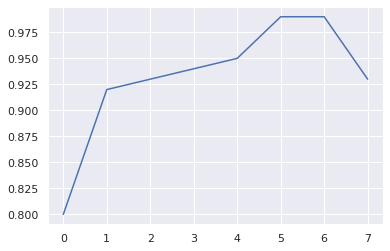

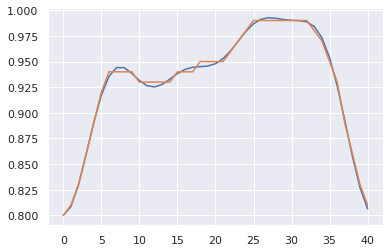

[0.8, 0.81, 0.83, 0.86, 0.89, 0.92, 0.94, 0.94, 0.94, 0.94, 0.93, 0.93, 0.93, 0.93, 0.93, 0.94, 0.94, 0.94, 0.95, 0.95, 0.95, 0.95, 0.96, 0.97, 0.98, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.98, 0.97, 0.95, 0.93, 0.89, 0.86, 0.83, 0.81]


In [42]:
#percentages for resnet
from scipy.signal import resample
x = [0.8, 0.92, 0.93, 0.94, 0.95, 0.99, 0.99, 0.93]
plt.plot(x)
plt.show()
y = resample(x,41)
plt.plot(y)
y = [round(elem,2) for elem in y]
plt.plot(y)
plt.show()
print(y)

In [99]:
import glob, os, fileinput
from glob import glob
root_dir = '../configs'
os.chdir(root_dir)
replace = False
rem_bak = True
bak_to_ini = False
for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        path = os.path.join(subdir, file)
        if replace:
            with fileinput.FileInput(path, inplace=True, backup='.bak') as file:
                for line in file:
                    print(line.replace("'/media/lorenz/Volume/code/msc/pytorch-admm-pruning/logfiles/'", 
                                       "/media/lorenz/Volume/code/msc/pytorch-admm-pruning/logfiles/"),  end='')

        if rem_bak:
            if '.bak' in path:
                os.remove(path) 
        
        if bak_to_ini:
            if '.bak' in path:
                with open(path, 'r') as file :
                      filedata = file.read()

                print(path)
                path = path.replace('.bak', '')

                with open(path, 'w') as file:
                    file.write(filedata)
        